In [8]:
from IPython.lib.deepreload import original_import
%load_ext autoreload
%autoreload 2

import modular_ex4 as ex4
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift, gaussian_filter, rotate


#### 1. Align consecutive frames
    a. Lucas Kanade or Point Correspondences, you choose
    b. Create a transformation matrix for every two consecutive frames
    c. Debug: Use synthetic videos: no motion, simple translation,

Testing Structured Image with: Shift=(12, -8.2), Rot=2.5°

--- Results ---
Trans X: Expected 12.00 | Got 11.9550
Trans Y: Expected -8.20 | Got -8.2565
Rot deg: Expected 2.50 | Got 2.5021

Errors -> Trans: 0.0722 px, Rot: 0.0021 deg
✅ SUCCESS: Pyramids working on structured image!


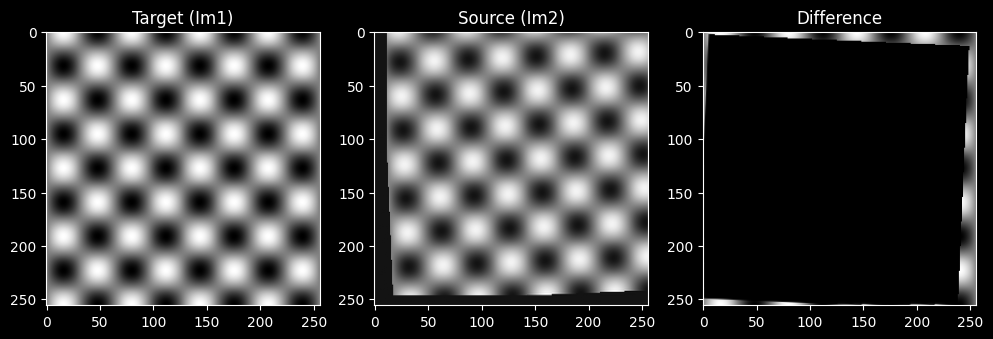

In [1]:
import numpy as np
import modular_ex4 as ex4
from scipy.ndimage import shift, rotate
import matplotlib.pyplot as plt


# --- 1. Create a STRUCTURED image (Sine Wave Grid) ---
# This mimics strong features like buildings or horizons that survive downscaling
def create_grid_image(size=256):
    x = np.linspace(-4 * np.pi, 4 * np.pi, size)
    y = np.linspace(-4 * np.pi, 4 * np.pi, size)
    xv, yv = np.meshgrid(x, y)
    # Create a smooth grid pattern
    im = np.sin(xv) * np.cos(yv)
    # Normalize to 0-1
    return (im - im.min()) / (im.max() - im.min())


im1 = create_grid_image(256)

# --- 2. Define Large Transformation ---
expected_u = 12
expected_v = -8.2
expected_deg = 2.5
expected_theta = np.deg2rad(expected_deg)

print(
    f"Testing Structured Image with: Shift=({expected_u}, {expected_v}), Rot={expected_deg}°")

# --- 3. Apply Transformation ---
# Rotate then Shift
im_rot = rotate(im1, angle=expected_deg, reshape=False, order=3)
im2 = shift(im_rot, shift=[expected_v, expected_u], order=3)

# --- 4. Run Optical Flow (Pyramids) ---
# Using border_cut=11 to capture enough gradient info
u_calc, v_calc, theta_calc = ex4.optical_flow(im1, im2, 16, 11)

# --- 5. Analysis ---
print("\n--- Results ---")
print(f"Trans X: Expected {expected_u:.2f} | Got {u_calc:.4f}")
print(f"Trans Y: Expected {expected_v:.2f} | Got {v_calc:.4f}")
print(
    f"Rot deg: Expected {expected_deg:.2f} | Got {np.rad2deg(theta_calc):.4f}")

err_trans = np.sqrt((u_calc - expected_u) ** 2 + (v_calc - expected_v) ** 2)
err_rot_deg = abs(np.rad2deg(theta_calc) - expected_deg)

print(f"\nErrors -> Trans: {err_trans:.4f} px, Rot: {err_rot_deg:.4f} deg")

if err_trans < 0.5 and err_rot_deg < 0.2:
    print("✅ SUCCESS: Pyramids working on structured image!")
else:
    print("❌ FAIL: Still diverging.")

# Debug Plot: Check if the 'Correction' makes sense
# If the logic is correct, applying the NEGATIVE flow to im2 should make it look like im1
im2_corrected = ex4.warp_image(im2, u_calc, v_calc, theta_calc)

# Note: Depending on your warp definition, you might need to pass (-u, -v, -theta)
# to 'undo' the motion. Let's try to visualize the diff.

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(im1, cmap='gray');
axes[0].set_title('Target (Im1)')
axes[1].imshow(im2, cmap='gray');
axes[1].set_title('Source (Im2)')
# Show difference between Target and Warped Source
axes[2].imshow(np.abs(im1 - im2_corrected), cmap='gray');
axes[2].set_title('Difference')
plt.show()

40+u:60+u =(41, 62), 40+v:60+v =(41, 62)
Expected shift: u=1, v=2


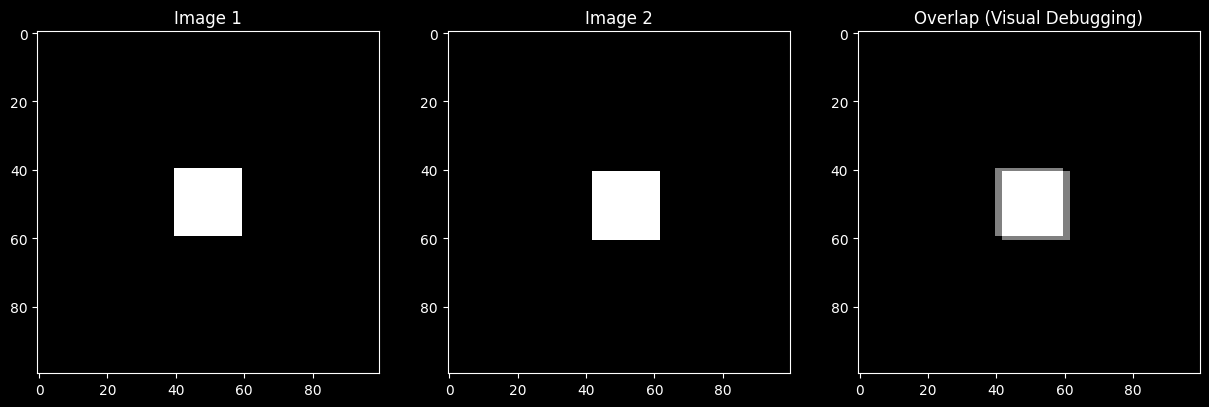

In [2]:
im1 = np.zeros((100, 100))
im1[40:60, 40:60] = 1
im2 = np.zeros((100, 100))
u, v = 1, 2
im2[40 + u:60 + u, 40 + v:60 + v] = 1  # Shifted by 1 pixel
print(f"40+u:60+u ={40 + u, 60 + v}, 40+v:60+v ={40 + u, 60 + v}")
# print("diff is: ",abs(40+u - (60+v)))
# 2. Plotting side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
# Image 1
axes[0].imshow(im1, cmap='gray')
axes[0].set_title("Image 1")
# Image 2
axes[1].imshow(im2, cmap='gray')
axes[1].set_title("Image 2")
# Overlap
axes[2].imshow(im1 + im2, cmap='gray')
axes[2].set_title("Overlap (Visual Debugging)")

# axes.imshow(im1 + im2, cmap='gray')
print(f"Expected shift: u={u}, v={v}")
# plt.show()

In [4]:
u2, v2, theta = ex4._lucas_kanade_step(im1, im2, 3)
print(f"Calculated shift: u={u2}, v={v2}, theta={theta}")

Calculated shift: u=0.9463027403218791, v=0.903697259678121, theta=-0.007394519356241845


In [ ]:
# 1. Setup specific shifts
expected_u = 0.1  # Horizontal shift (x)
expected_v = 0.2  # Vertical shift (y)
expected_theta = 0.0  # No rotation for this test

# 2. Create rich texture image (Smoothed Noise)
# Using a slightly larger image helps distinguish rotation from translation
im1 = np.random.rand(150, 150)
im1 = gaussian_filter(im1, sigma=2.0)

# 3. Apply Shift accurately
# Note: scipy shift takes (axis_0_shift, axis_1_shift) -> (v, u)
im2 = shift(im1, shift=[expected_v, expected_u], order=3)
# 4. Run your Rigid LK
u_calc, v_calc, theta_calc = ex4.lucas_kanade_step(im1, im2, border_cut=10)

print(f"Expected: u={expected_u}, v={expected_v}, theta=0")
print(f"Got:      u={u_calc:.4f}, v={v_calc:.4f}, theta={theta_calc:.6f}")

# 5. Analysis
error_trans = np.sqrt((u_calc - expected_u) ** 2 + (v_calc - expected_v) ** 2)
print(f"Translation Error: {error_trans:.4f}")

if error_trans < 0.1 and abs(theta_calc) < 0.01:
    print("✅ SUCCESS: Axis logic and Solver are correct.")
else:
    print("❌ FAIL: Still a mismatch. Check matrix construction.")

In [10]:
# 1. Define Transformation
# Let's try a realistic scenario for video stabilization:
expected_u = 0.1  # Translation x
expected_v = -0.2  # Translation y
expected_deg = 2.5  # Rotation in Degrees (Small rotation)

# Convert to radians for comparison with our algorithm output
expected_theta = np.deg2rad(expected_deg)

# 2. Create Image
im1 = np.random.rand(150, 150)
im1 = gaussian_filter(im1, sigma=2.0)

# 3. Apply Transformations (Scipy style)
# Order matters! Usually rotation happens around center, then translation.
# reshape=False keeps the image size 200x200 (crops corners)
im_rot = rotate(im1, angle=expected_deg, reshape=False, order=3)
im2 = shift(im_rot, shift=[expected_v, expected_u], order=3)

# 4. Run Optical Flow (Pyramids)
# Note: Increasing window size slightly (to 7 or 9) can help with rotation
u_calc, v_calc, theta_calc = ex4._lucas_kanade_step(im1, im2, 10)

# 5. Compare Results
print(f"--- Translation ---")
print(f"Expected (u, v): ({expected_u}, {expected_v})")
print(f"Got      (u, v): ({u_calc:.4f}, {v_calc:.4f})")

print(f"\n--- Rotation ---")
print(f"Expected (rad): {expected_theta:.6f}  (approx {expected_deg} deg)")
print(
    f"Got      (rad): {theta_calc:.6f}  (approx {np.rad2deg(theta_calc):.4f} deg)")

# 6. Success Logic
err_trans = np.sqrt((u_calc - expected_u) ** 2 + (v_calc - expected_v) ** 2)
err_rot = abs(theta_calc - expected_theta)

print(f"\nErrors -> Trans: {err_trans:.4f}, Rot: {err_rot:.4f}")

if err_trans < 0.2 and err_rot < 0.01:
    print("✅ SUCCESS: The algorithm handles both Rotation and Translation!")
else:
    print("❌ FAIL: Deviations are too large.")

--- Translation ---
Expected (u, v): (0.1, -0.2)
Got      (u, v): (0.0926, -0.0953)

--- Rotation ---
Expected (rad): 0.043633  (approx 2.5 deg)
Got      (rad): 0.029645  (approx 1.6985 deg)

Errors -> Trans: 0.1050, Rot: 0.0140
❌ FAIL: Deviations are too large.


#### 2. Stabilize Rotations & Y translations
    a. Debug: Use synthetic videos: no motion, simple translation, rotation...
    b. Create - warp frames to get a stable video (only horizontal motion)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.ndimage import shift, rotate, gaussian_filter
import modular_ex4 as ex4


# --- Helper Function to Create a Grid Image ---
def create_grid_image(size=200):
    x = np.linspace(-4 * np.pi, 4 * np.pi, size)
    y = np.linspace(-4 * np.pi, 4 * np.pi, size)
    xv, yv = np.meshgrid(x, y)
    im = np.sin(xv) * np.cos(yv)
    return (im - im.min()) / (im.max() - im.min())


# 1. Generate Synthetic "Shaky" Video
# -----------------------------------
print("Generating synthetic video...")
base_im = create_grid_image(200)

num_frames = 20
original_frames = [base_im]
true_drifts = []

current_im = base_im

for i in range(1, num_frames):
    # Define Motion:
    # 1. Desired Motion: Moving smoothly to the right (panning)
    dx = 5.0

    # 2. Unwanted Noise (Drift): Random vertical shifts and rotations
    # TODO: replace to prev version
    dy = 0.0
    d_deg = 0.0
    # dy = np.random.uniform(-3, 3)       # Jitter in Y
    # d_deg = np.random.uniform(-1, 1)    # Jitter in Rotation (Degrees)

    true_drifts.append((dx, dy, d_deg))

    # Apply transformations to create the next frame
    # Order: Rotate -> Shift
    im_rot = rotate(current_im, angle=d_deg, reshape=False, order=3)
    im_next = shift(im_rot, shift=[dy, dx], order=3)

    original_frames.append(im_next)
    current_im = im_next

print(f"Created {len(original_frames)} frames with artificial shake.")

# 2. Run Stabilization Algorithm
# ------------------------------
print("Running stabilization...")
# Using step_size=16 and border_cut=15 (proven effective parameters)
step_size = 16
border_cut = 15
original_rgb_frames = to_rgb_sequence(original_frames)
stabilized_frames = ex4.stabilize_video(original_rgb_frames,
                                        step_size=step_size,
                                        border_cut=border_cut)

# TODO: Uncomment to display
# 3. Visualization & Comparison
# -----------------------------
# Compare the last frame to see the accumulated correction
last_idx = num_frames - 1

plt.figure(figsize=(12, 6))

# Original Last Frame (Should be tilted and vertically shifted)
plt.subplot(1, 2, 1)
plt.imshow(original_frames[last_idx], cmap='gray')
plt.title(f"Original Frame {last_idx}\n(Drifted & Shaky)")

# Stabilized Last Frame (Should be straight and horizontally aligned)
plt.subplot(1, 2, 2)
plt.imshow(stabilized_frames[last_idx], cmap='gray')
plt.title(f"Stabilized Frame {last_idx}\n(Corrected Y & Theta)")

plt.show()

# 4. Animation (Optional)
# -----------------------
# Displays side-by-side comparison video
print("Building animation...")

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title("Original (Shaky)")
ax[1].set_title("Stabilized (Smooth)")
ax[0].axis('off')
ax[1].axis('off')

im_disp1 = ax[0].imshow(original_frames[0], cmap='gray', animated=True)
im_disp2 = ax[1].imshow(stabilized_frames[0], cmap='gray', animated=True)


def update(i):
    im_disp1.set_data(original_frames[i])
    im_disp2.set_data(stabilized_frames[i])
    return im_disp1, im_disp2


ani = animation.FuncAnimation(fig, update, frames=len(original_frames),
                              interval=200, blit=True)
plt.close()  # Prevent static display of the plot

# Display animation in Jupyter
HTML(ani.to_jshtml())

Generating synthetic video...
Created 20 frames with artificial shake.
Running stabilization...


AttributeError: 'list' object has no attribute 'ndim'

#### 3. Use motion composition to align all frames to same coordinates.
    a. Compute canvas size from motion matrices
    b. Create - paste aligned frames into canvas on top of each other


In [12]:
mtx = ex4.compute_camera_path(
    stabilized_frames, step_size=step_size, border_cut=border_cut)
canvas_h, canvas_w, offset_y, offset_x = ex4.compute_canvas_geometry(
    mtx, stabilized_frames.shape[1], stabilized_frames.shape[2])
panorama = ex4.render_strip_panorama(
    original_rgb_frames,
    mtx,
    (canvas_h, canvas_w, offset_y, offset_x),
    grayscale_out=True,
)
plt.figure(figsize=(15, 6))
plt.imshow(panorama, cmap='gray')
plt.title("Step 3b: Full Mosaic (Overlay)")
# plt.axis('off') # Hide axes for cleaner view
plt.show()

NameError: name 'stabilized_frames' is not defined

#### 4. Create mosaic by pasting strips using correct width & location
    a. Start with synthetic videos at constant translation & no rotation...
    b. Back Warping from canvas to frame...


Generating sharp checkerboard frames...
Created 20 frames. Each moves exactly 5 pixels to the right.
Running create_mosaic...


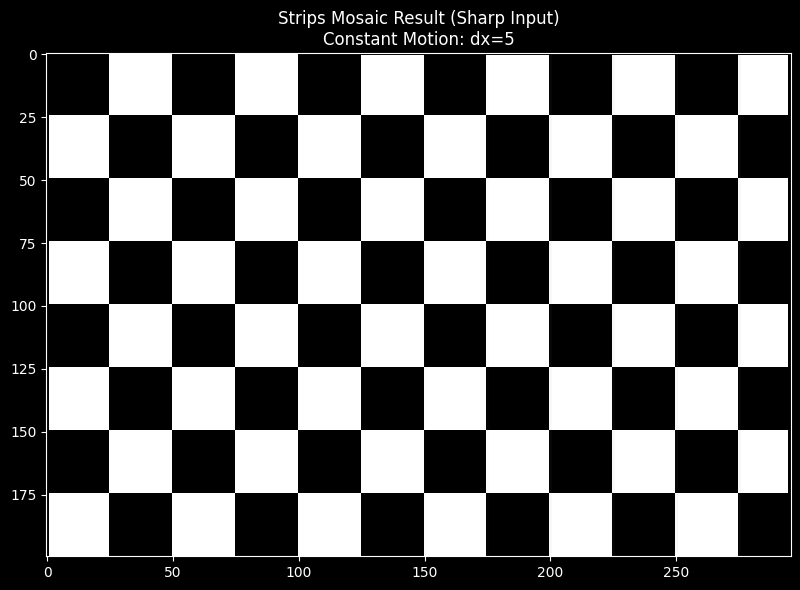

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import modular_ex4 as ex4

def create_sharp_checkerboard(h, w, block_size=25):
    """
    Creates a sharp 0/1 checkerboard pattern.
    """
    # Create grid of indices
    rows = np.arange(h) // block_size
    cols = np.arange(w) // block_size

    # Checkerboard pattern logic: (row_index + col_index) is even or odd
    # Using broadcasting to create the 2D mask
    board = (rows[:, None] + cols[None, :]) % 2

    return board.astype(np.float64)

# 1. Setup Parameters
H, W = 200, 200    # Frame size
num_frames = 20
dx = 5             # Exact horizontal shift per frame

# Calculate total width needed for the "world"
total_width_needed = W + (num_frames * dx) + 50

print("Generating sharp checkerboard frames...")

# Generate one big wide board first (Ground Truth)
world_map = create_sharp_checkerboard(H, total_width_needed, block_size=25)

frames = []
for i in range(num_frames):
    # Simulate camera panning by slicing the world map directly
    start_x = i * dx
    end_x = start_x + W

    # Extract frame
    current_frame = world_map[:, start_x:end_x]
    frames.append(current_frame)

print(f"Created {len(frames)} frames. Each moves exactly {dx} pixels to the right.")

# 2. Run the Mosaic Stitching
print("Running create_mosaic...")
# Note: border_cut is just passed to alignment, assuming your alignment works well on this
# todo: replace with your function here
frames_rgb = np.stack([np.repeat(frame[..., None], 3, axis=2) for frame in frames], axis=0)
mtx = ex4.compute_camera_path(frames_rgb, step_size=16, border_cut=15)
geo = ex4.compute_canvas_geometry(mtx, frames_rgb.shape[1], frames_rgb.shape[2])
panorama = ex4.render_strip_panorama(frames_rgb, mtx, geo, grayscale_out=True)
plt.figure(figsize=(15, 6))
plt.imshow(panorama, cmap='gray', interpolation='nearest')
plt.title(f"Strips Mosaic Result (Sharp Input)\nConstant Motion: dx={dx}")
plt.tight_layout()
plt.show()

Generating world map...
Simulating camera movement with jitter...
Frame 0: Pos=(100, 128.79), Angle=-1.60°
Frame 1: Pos=(105, 130.14), Angle=-0.51°
Frame 2: Pos=(110, 130.36), Angle=1.40°
Frame 3: Pos=(115, 130.21), Angle=0.09°
Frame 4: Pos=(120, 129.48), Angle=1.56°
Frame 5: Pos=(125, 128.30), Angle=1.89°
Frame 6: Pos=(130, 130.21), Angle=0.30°
Frame 7: Pos=(135, 128.50), Angle=1.41°
Frame 8: Pos=(140, 129.28), Angle=-0.11°
Frame 9: Pos=(145, 129.74), Angle=-1.09°
Frame 10: Pos=(150, 128.84), Angle=0.55°
Frame 11: Pos=(155, 127.41), Angle=-0.30°
Frame 12: Pos=(160, 127.34), Angle=1.91°
Frame 13: Pos=(165, 128.14), Angle=0.68°
Frame 14: Pos=(170, 127.93), Angle=-0.13°
Frame 15: Pos=(175, 131.74), Angle=-1.32°
Frame 16: Pos=(180, 130.08), Angle=0.01°
Frame 17: Pos=(185, 132.11), Angle=0.00°
Frame 18: Pos=(190, 131.49), Angle=0.22°
Frame 19: Pos=(195, 127.86), Angle=-1.53°
Done! Created 20 noisy_frames with translation and rotation noise.


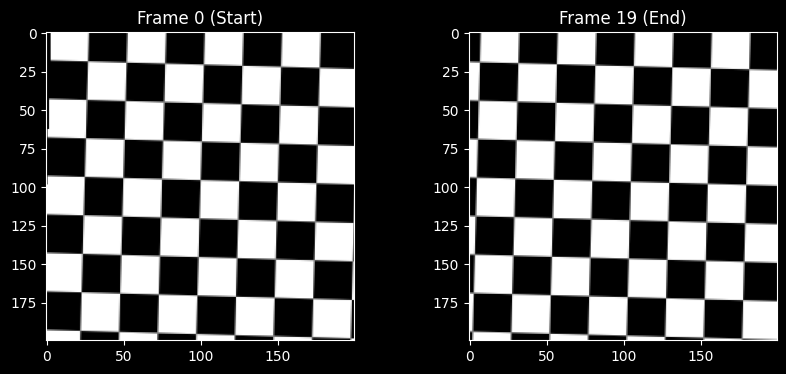

In [22]:
#import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

def create_sharp_checkerboard(h, w, block_size=25):
    """
    Creates a sharp 0/1 checkerboard pattern.
    """
    rows = np.arange(h) // block_size
    cols = np.arange(w) // block_size
    board = (rows[:, None] + cols[None, :]) % 2
    return board.astype(np.float64)

def get_camera_frame(world_map, center_x, center_y, theta_deg, frame_h, frame_w):
    """
    Simulates a camera capturing a frame from the world map at a specific location and rotation.
    """
    # 1. Create a grid of coordinates for the camera frame (centered at 0,0)
    Y, X = np.mgrid[0:frame_h, 0:frame_w]

    # Center the coordinates so rotation happens around the middle of the frame
    X_centered = X - frame_w // 2
    Y_centered = Y - frame_h // 2

    # 2. Rotate coordinates (Inverse Warp logic)
    # Convert degrees to radians
    theta_rad = np.deg2rad(theta_deg)
    c, s = np.cos(theta_rad), np.sin(theta_rad)

    # Rotate (Standard 2D rotation matrix)
    # Note: To find which pixel in 'World' corresponds to (x,y) in 'Camera',
    # we apply the rotation to the relative coordinates.
    src_x_rel = c * X_centered - s * Y_centered
    src_y_rel = s * X_centered + c * Y_centered

    # 3. Translate to the world position
    src_x = src_x_rel + center_x
    src_y = src_y_rel + center_y

    # 4. Sample from the world map using interpolation
    # order=1 (linear) preserves sharpness reasonably well while allowing sub-pixel rotation
    frame = map_coordinates(world_map, [src_y, src_x], order=1, mode='constant', cval=0.0)

    return frame

# --- Main Simulation ---

# 1. Setup Parameters
H, W = 200, 200      # Camera Frame size
num_frames = 20
dx = 5               # Steady horizontal speed

# We need a slightly taller world to allow for vertical jitter and rotation without seeing black edges immediately
world_padding_y = 60
world_H = H + world_padding_y
total_width_needed = W + (num_frames * dx) + 100

print("Generating world map...")
world_map = create_sharp_checkerboard(world_H, total_width_needed, block_size=25)

noisy_frames = []
camera_positions = [] # To keep track of ground truth if needed

# Initial Camera Center in the World
current_center_x = W // 2
current_center_y = world_H // 2

print("Simulating camera movement with jitter...")

for i in range(num_frames):
    # 1. Calculate ideal position (Steady movement)
    # We advance X by dx each frame (+ small noise)
    step_x = dx + np.random.uniform(-1, 1)

    # 2. Add Random Jitter (Noise)
    # The user defined jitter range:
    dy_noise = np.random.uniform(-3, 3)     # Jitter in Y
    d_deg_noise = np.random.uniform(-2, 2)  # Jitter in Rotation

    # Update camera state
    # Note: We update the center_x based on the steady flow (i * dx),
    # but we add the jitter to the Y and Angle.

    # Position for this frame:
    frame_center_x = (W // 2) + (i * dx)  # Steady pan
    frame_center_y = (world_H // 2) + dy_noise
    frame_theta = d_deg_noise # Rotation relative to horizon (jitter around 0)

    # Generate the frame
    frame = get_camera_frame(world_map,
                             frame_center_x,
                             frame_center_y,
                             frame_theta,
                             H, W)

    noisy_frames.append(frame)

    # Optional: Print status
    print(f"Frame {i}: Pos=({frame_center_x}, {frame_center_y:.2f}), Angle={frame_theta:.2f}°")

print(f"Done! Created {len(noisy_frames)} noisy_frames with translation and rotation noise.")

# Optional: Visualize the first and last frame
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(noisy_frames[0], cmap='gray')
plt.title("Frame 0 (Start)")
plt.subplot(1, 2, 2)
plt.imshow(noisy_frames[-1], cmap='gray')
plt.title(f"Frame {num_frames-1} (End)")
plt.show()

Running create_mosaic...


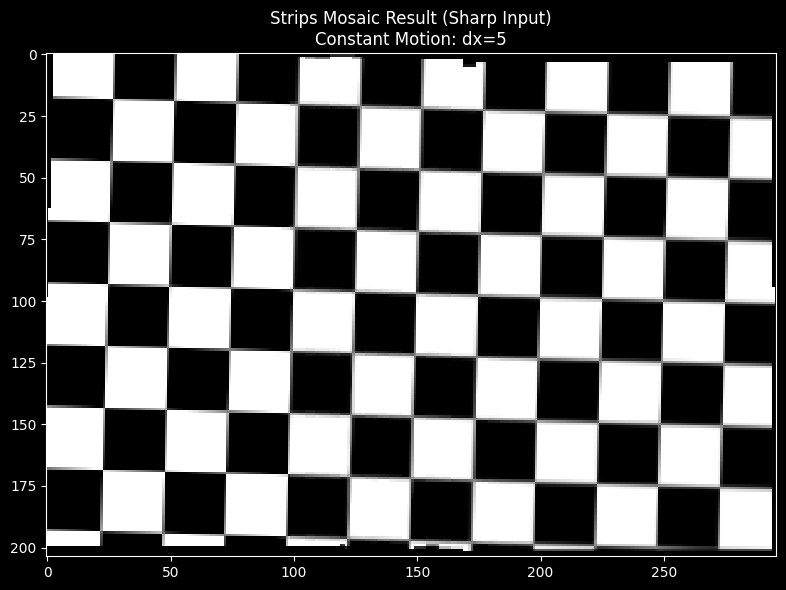

In [23]:
# 2. Run the Mosaic Stitching
print("Running create_mosaic...")
# Note: border_cut is just passed to alignment, assuming your alignment works well on this
raw_frames = np.stack([np.repeat(frame[..., None], 3, axis=2) for frame in noisy_frames], axis=0)
step_size, border_cut = 16, 15
stable_frames = ex4.stabilize_video(raw_frames, step_size=step_size, border_cut=border_cut)

mtx = ex4.compute_camera_path(stable_frames, step_size=step_size, border_cut=border_cut)

geo = ex4.compute_canvas_geometry(mtx, raw_frames.shape[1], raw_frames.shape[2])

panorama = ex4.render_strip_panorama(stable_frames, mtx, geo, grayscale_out=True)
plt.figure(figsize=(15, 6))
plt.imshow(panorama, cmap='gray', interpolation='nearest')
plt.title(f"Strips Mosaic Result (Sharp Input)\nConstant Motion: dx={dx}")
plt.tight_layout()
plt.show()

#### 5. Set convergence point (With no setting - this is infinity)
    a. Depth point that does not move between mosaics